<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/01_Data_Acquisition_EDA/Data_Acquisition_BLS_SEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#Retrieve Data from Wikapedia Via Web Scrape
import pandas as pd

def getSandP500Constituents(path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/'):
  link = (
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks"
  )
  data = pd.read_html(link, header=0)[0]
  data.to_csv(path + "constituents.csv", index=False)
  return data

In [5]:
#use above function
constituents_data = getSandP500Constituents()

In [7]:
constituents_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             503 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [13]:
#Retrieve Data from BLS
import requests

def getBLSData(series, base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/', path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/', label = ''):
  data_url = '{}{}'.format(base_url, series['id'])
  myHeaders = {'Content-type': 'application/json'}
  APIRequest = requests.get(data_url, params=series, headers=myHeaders).json()
  print('Status: ' + APIRequest['status'])
  data = pd.DataFrame(APIRequest['Results']['series'][0]['data'])
  data.to_csv(path + label + '_' + series['id'] + ".csv", index=False)
  return data

In [19]:
#use above funciton

CPISeriesInfo = {'id': 'CUSR0000SA0',
                'name': 'All items in U.S. city average, all urban consumers, seasonally adjusted',
                "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

CPIDataframe = getBLSData(series=CPISeriesInfo, label= 'CPI')

Status: REQUEST_SUCCEEDED


In [20]:
CPIDataframe

,year,period,periodName,latest,value,footnotes,calculations
0,2023,M10,October,true,307.619,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.0'..."
1,2023,M09,September,NaN,307.481,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.4'..."
2,2023,M08,August,NaN,306.269,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.6'..."
3,2023,M07,July,NaN,304.348,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.2'..."
4,2023,M06,June,NaN,303.841,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.2'..."
...,...,...,...,...,...,...,...
185,2008,M05,May,NaN,215.208,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.6'..."
186,2008,M04,April,NaN,213.942,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.2'..."
187,2008,M03,March,NaN,213.448,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.4'..."
188,2008,M02,February,NaN,212.687,[{}],"{'net_changes': {}, 'pct_changes': {'1': '0.2'..."


In [21]:
# CPI EDA
CPIDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          190 non-null    object
 1   period        190 non-null    object
 2   periodName    190 non-null    object
 3   latest        1 non-null      object
 4   value         190 non-null    object
 5   footnotes     190 non-null    object
 6   calculations  190 non-null    object
dtypes: object(7)
memory usage: 10.5+ KB


In [22]:
#prelimary preprocessing - get time, fix data types, unpack nested data
import datetime

CPIDateTime = CPIDataframe['value'].copy() # get a series the length of the df
CPIMoMPercent = CPIDataframe['value'].copy() # get a series the length of the df
CPI3MPercent = CPIDataframe['value'].copy() # get a series the length of the df
CPI6MPercent = CPIDataframe['value'].copy() # get a series the length of the df
CPIYoYPercent = CPIDataframe['value'].copy() # get a series the length of the df

for i, r in CPIDataframe.iterrows():
  CPIDateTime[i] = datetime.datetime(int(r['year']), int(r['period'][-2:]), 1)
  CPIMoMPercent[i] = r['calculations']['pct_changes']['1']
  CPI3MPercent[i] = r['calculations']['pct_changes']['3']
  CPI6MPercent[i] = r['calculations']['pct_changes']['6']
  CPIYoYPercent[i] = r['calculations']['pct_changes']['12']

CPIDataframe['DateTime'] = CPIDateTime.apply(pd.to_datetime)
CPIDataframe['MonthOverMonth'] = CPIMoMPercent.apply(float)
CPIDataframe['3-Month'] = CPI3MPercent.apply(float)
CPIDataframe['6-Month'] = CPI6MPercent.apply(float)
CPIDataframe['YearOverYear'] = CPIYoYPercent.apply(float)
CPIDataframe['value'] = CPIDataframe['value'].apply(float)

CPIDataframe.to_csv("/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/CPI_flattened.csv", index=False)

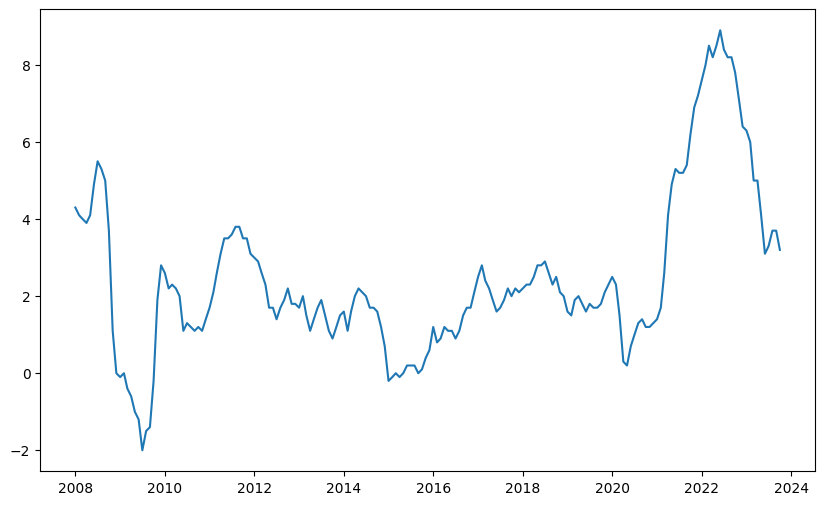

In [17]:
#plot
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.plot(CPIDataframe['DateTime'], CPIDataframe['YearOverYear'])
plt.show()

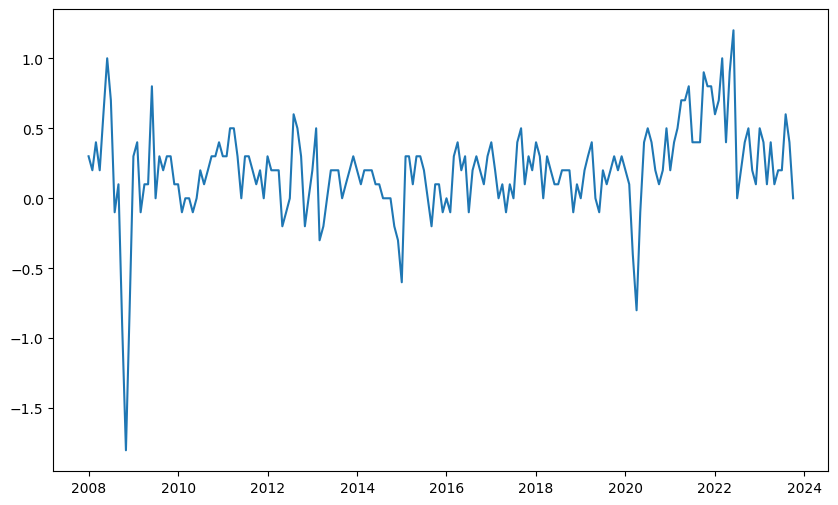

In [23]:
plt.figure(figsize = (10,6))
plt.plot(CPIDataframe['DateTime'], CPIDataframe['MonthOverMonth'])
plt.show()

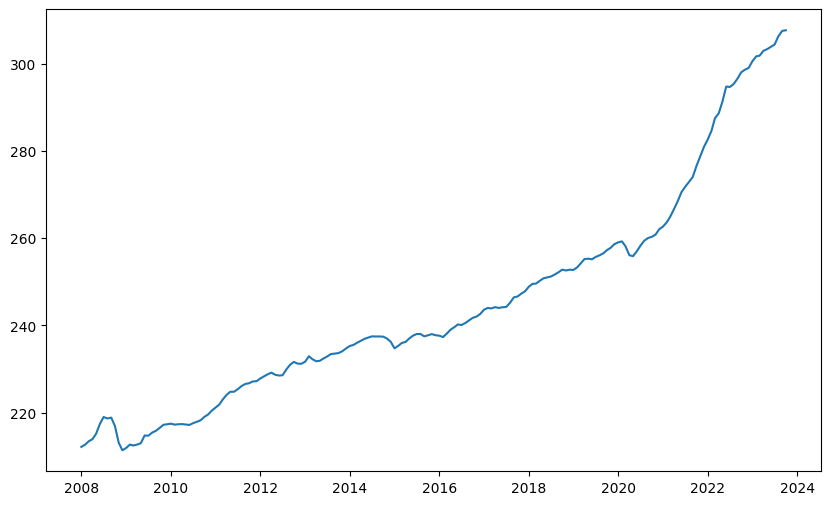

In [24]:
plt.figure(figsize = (10,6))
plt.plot(CPIDataframe['DateTime'], CPIDataframe['value'])
plt.show()

In [25]:
# Unemployment Data
UnemploySeriesInfo = {'id': 'LNS14000000',
                    'name': 'Unemployment Rate, seasonally adjusted',
                    "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

UnemploymentDataframe = getBLSData(series=UnemploySeriesInfo, label= 'Unemployment')

Status: REQUEST_SUCCEEDED


In [26]:
#prelimary preprocessing - get time, fix data types, unpack nested data

UnemploymentDateTime = UnemploymentDataframe['value'].copy() # get a series the length of the df
UnemploymentMoMPercent = UnemploymentDataframe['value'].copy() # get a series the length of the df
Unemployment3MPercent = UnemploymentDataframe['value'].copy() # get a series the length of the df
Unemployment6MPercent = UnemploymentDataframe['value'].copy() # get a series the length of the df
UnemploymentYoYPercent = UnemploymentDataframe['value'].copy() # get a series the length of the df

for i, r in UnemploymentDataframe.iterrows():
  UnemploymentDateTime[i] = datetime.datetime(int(r['year']), int(r['period'][-2:]), 1)
  UnemploymentMoMPercent[i] = r['calculations']['net_changes']['1']
  Unemployment3MPercent[i] = r['calculations']['net_changes']['3']
  Unemployment6MPercent[i] = r['calculations']['net_changes']['6']
  UnemploymentYoYPercent[i] = r['calculations']['net_changes']['12']

UnemploymentDataframe['DateTime'] = UnemploymentDateTime.apply(pd.to_datetime)
UnemploymentDataframe['MonthOverMonth'] = UnemploymentMoMPercent.apply(float)
UnemploymentDataframe['3-Month'] = Unemployment3MPercent.apply(float)
UnemploymentDataframe['6-Month'] = Unemployment6MPercent.apply(float)
UnemploymentDataframe['YearOverYear'] = UnemploymentYoYPercent.apply(float)
UnemploymentDataframe['value'] = UnemploymentDataframe['value'].apply(float)

UnemploymentDataframe.to_csv("/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/unemployment_flattened.csv", index=False)

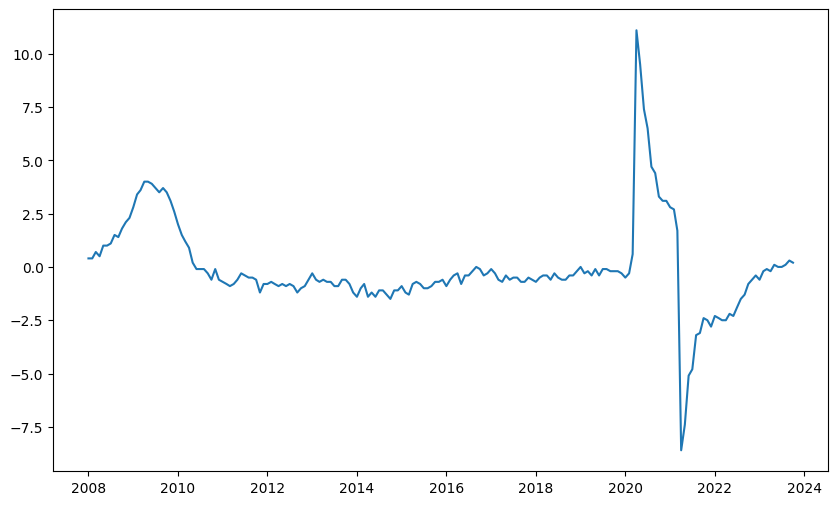

In [27]:
plt.figure(figsize = (10,6))
plt.plot(UnemploymentDataframe['DateTime'], UnemploymentDataframe['YearOverYear'])
plt.show()

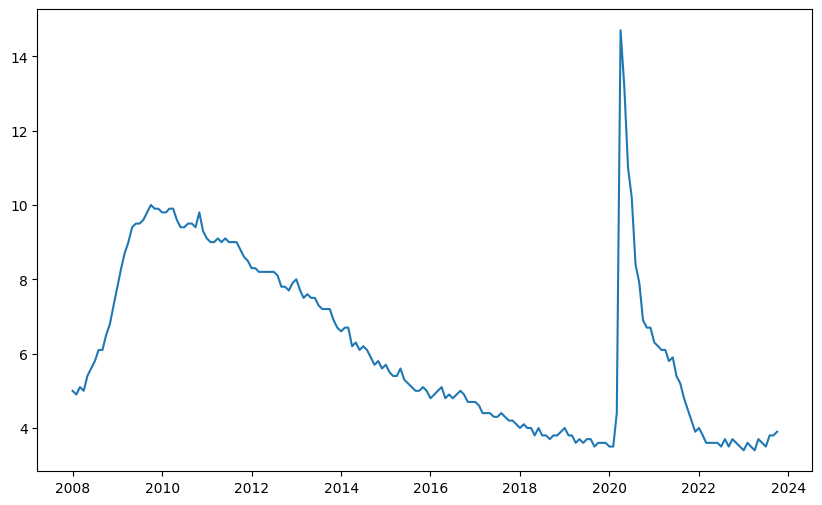

In [28]:
plt.figure(figsize = (10,6))
plt.plot(UnemploymentDataframe['DateTime'], UnemploymentDataframe['value'])
plt.show()

In [35]:
# PPI Data 1
ppiSeriesInfo = {'id': 'PCUOMFG--OMFG--',
                'name': 'PPI industry group data for Total manufacturing industries, not seasonally adjusted',
                 "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

ppiDataframe = getBLSData(series=ppiSeriesInfo, label='PPI_manufacturing')

Status: REQUEST_SUCCEEDED


In [33]:
#PPI Data 2
ppiSeriesInfo = {'id': 'PCU22112222112241',
                'name': 'PPI industry - seasonally adjusted',
                 "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

ppiDataframe = getBLSData(series=ppiSeriesInfo, label='PPI_industry')

Status: REQUEST_SUCCEEDED


In [31]:
#PPI Data 3
ppiSeriesInfo = {'id': 'WPS141101',
                'name': 'PPI commodities - seasonally adjusted',
                 "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

ppiDataframe = getBLSData(series=ppiSeriesInfo, label='PPI_commod')

Status: REQUEST_SUCCEEDED


In [36]:
#prelimary preprocessing - get time, fix data types, unpack nested data

ppiDateTime = ppiDataframe['value'].copy() # get a series the length of the df
ppiMoMPercent = ppiDataframe['value'].copy() # get a series the length of the df
ppi3MPercent = ppiDataframe['value'].copy() # get a series the length of the df
ppi6MPercent = ppiDataframe['value'].copy() # get a series the length of the df
ppiYoYPercent = ppiDataframe['value'].copy() # get a series the length of the df

for i, r in ppiDataframe.iterrows():
  ppiDateTime[i] = datetime.datetime(int(r['year']), int(r['period'][-2:]), 1)
  ppiMoMPercent[i] = r['calculations']['pct_changes']['1']
  ppi3MPercent[i] = r['calculations']['pct_changes']['3']
  ppi6MPercent[i] = r['calculations']['pct_changes']['6']
  ppiYoYPercent[i] = r['calculations']['pct_changes']['12']

ppiDataframe['DateTime'] = ppiDateTime.apply(pd.to_datetime)
ppiDataframe['MonthOverMonth'] = ppiMoMPercent.apply(float)
ppiDataframe['3-Month'] = ppi3MPercent.apply(float)
ppiDataframe['6-Month'] = ppi6MPercent.apply(float)
ppiDataframe['YearOverYear'] = ppiYoYPercent.apply(float)
ppiDataframe['value'] = ppiDataframe['value'].apply(float)

ppiDataframe.to_csv("/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/PPI_manufacturing_flattened.csv", index=False)

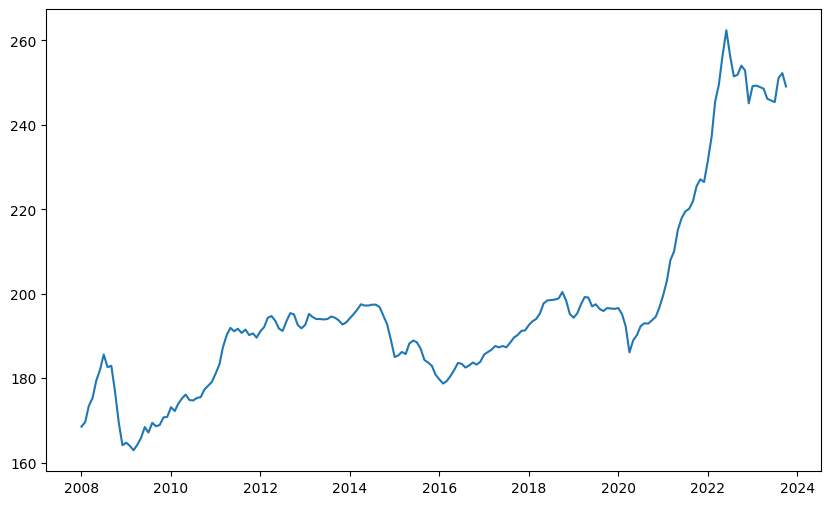

In [37]:
plt.figure(figsize = (10,6))
plt.plot(ppiDataframe['DateTime'], ppiDataframe['value'])
plt.show()

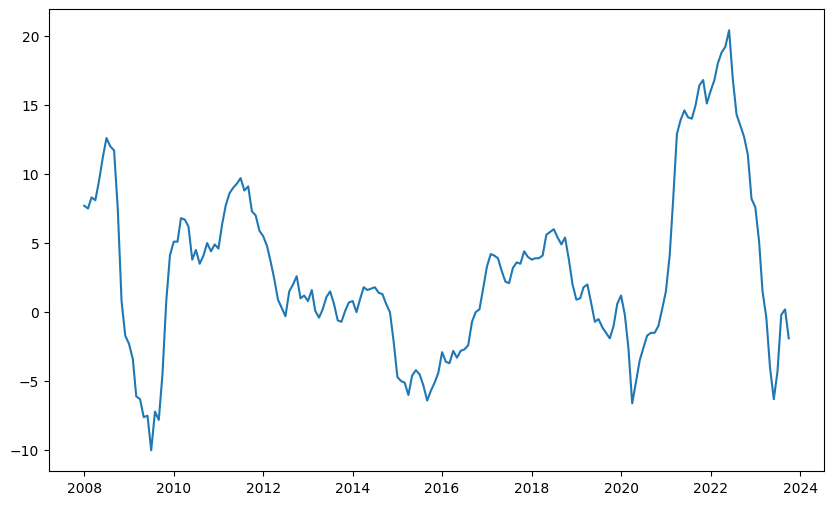

In [38]:
plt.figure(figsize = (10,6))
plt.plot(ppiDataframe['DateTime'], ppiDataframe['YearOverYear'])
plt.show()

In [39]:
#Consumer Expenditure Survey Data
cesSeriesInfo = {'id': 'CXUMENBOYSLB0101M',
                    'name': 'Consumer Expenditure Survey',
                 "startyear":"2008",
                "endyear":"2023",
                "calculations":True,
                "registrationkey":"f64b67c8434042938fb3fc23bc840110"}

cesDataframe = getBLSData(series=cesSeriesInfo, label='ConsumerExpenditureSurvey')

Status: REQUEST_SUCCEEDED


In [40]:
#prelimary preprocessing - get time, fix data types, unpack nested data

cesDateTime = cesDataframe['value'].copy() # get a series the length of the df
cesYoYPercent = cesDataframe['value'].copy() # get a series the length of the df

for i, r in cesDataframe.iterrows():
  cesDateTime[i] = datetime.datetime(int(r['year']), int(r['period'][-2:]), 1)
  cesYoYPercent[i] = r['calculations']['pct_changes']['12']

cesDataframe['DateTime'] = cesDateTime.apply(pd.to_datetime)
cesDataframe['YearOverYear'] = cesYoYPercent.apply(float)
cesDataframe['value'] = cesDataframe['value'].apply(float)

cesDataframe.to_csv("/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/ConsumerExpenditureSurvey_flattened.csv", index=False)

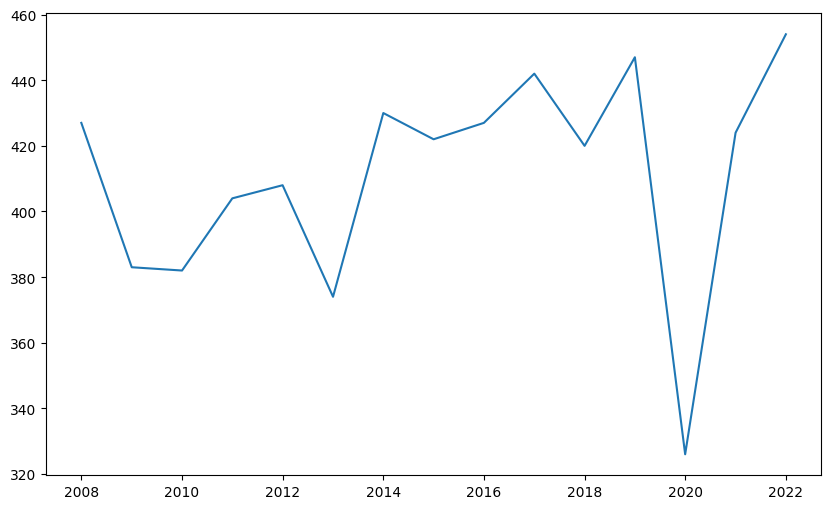

In [41]:
plt.figure(figsize = (10,6))
plt.plot(cesDataframe['DateTime'], cesDataframe['value'])
plt.show()

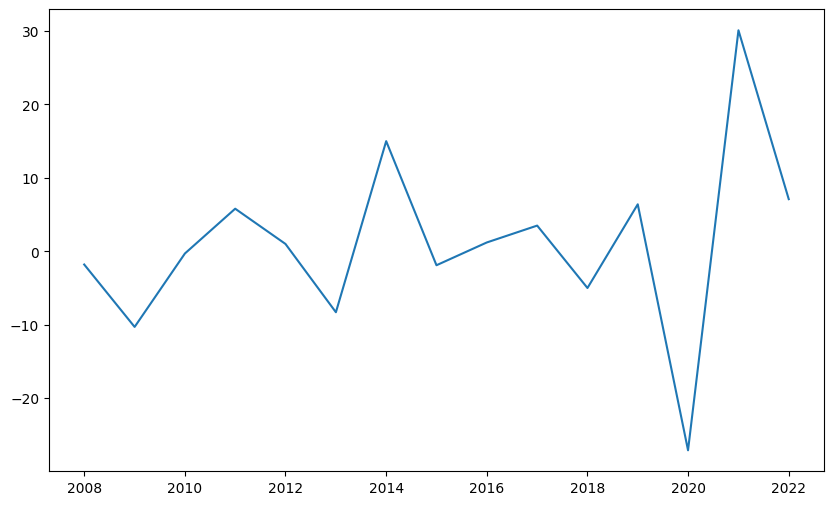

In [42]:
plt.figure(figsize = (10,6))
plt.plot(cesDataframe['DateTime'], cesDataframe['YearOverYear'])
plt.show()

In [43]:
#SEC Data
%pip install -U sec-edgar-api
import sec_edgar_api as sec

In [ ]:
import pandas as pd

#create SEC look up table of financial information
myClient = sec.EdgarClient(user_agent="Jimmy Zhang <jz876@drexel.edu>")
merckFacts =myClient.get_company_facts(cik="310158") #cik for merck
merckSECFilings = merckFacts['facts']['us-gaap']
lookupTable = pd.DataFrame(merckSECFilings.values(), columns= ['label','description'])
lookupTable.head(n=7)

,label,description
0,"Accounts Payable, Current",Carrying value as of the balance sheet date of...
1,"Accounts Receivable, after Allowance for Credi...","Amount, after allowance for credit loss, of ri..."
2,"Accounts Receivable, after Allowance for Credi...","Amount, after allowance for credit loss, of ri..."
3,"Accounts Receivable, Sale",Amount of decrease from sale of accounts recei...
4,Accrual for Environmental Loss Contingencies,Total costs accrued as of the balance sheet da...
5,"Accrued Income Taxes, Current",Carrying amount as of the balance sheet date o...
6,"Accumulated Depreciation, Depletion and Amorti...","Amount of accumulated depreciation, depletion ..."


In [ ]:
#function to get SEC Filings and Download it in csv format
import os

def getSECData(CIK, ticker='not_specified', path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/SEC/'):
  myClient = sec.EdgarClient(user_agent="Jimmy Zhang <jz876@drexel.edu>")
  companyFacts =myClient.get_company_facts(cik=CIK)
  myTickerFolder = os.path.join(path, ticker)
  if not os.path.exists(myTickerFolder):
    os.mkdir(os.path.join(path, ticker))
  myData = companyFacts['facts']['us-gaap']
  mySeriesNames = list()
  myDfList = list()
  for k, v in myData.items():
    mySeriesNames.append(k)
    nestedKey = list(v['units'].keys())[0]
    myDfList.append(pd.DataFrame(v['units'][nestedKey]))
    myDfList[-1]['unit'] = nestedKey
    myDfList[-1].to_csv(os.path.join(path, ticker, k + ".csv"), index=False)
  return mySeriesNames, myDfList

In [ ]:
#testing the function with Merck SEC Data
merckDataSeriesNames, merckSECDfList = getSECData("310158", ticker = 'MRK')

In [ ]:
#alot of potential features from just one public company, Merck
merckDataSeriesNames

['AccountsPayableCurrent',
 'AccountsReceivableNetCurrent',
 'AccountsReceivableNetNoncurrent',
 'AccountsReceivableSale',
 'AccrualForEnvironmentalLossContingencies',
 'AccruedIncomeTaxesCurrent',
 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment',
 'AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'AcquiredFiniteLivedIntangibleAssetAmount',
 'AdditionalPaidInCapital',
 'AdditionalPaidInCapitalCommonStock',
 'AdjustmentForAmortization',
 'AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther',
 'AdjustmentsToAdditionalPaidInCapitalSharebasedCom

In [ ]:
print(merckDataSeriesNames[10])
merckSECDfList[10]

AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax


,end,val,accn,fy,fp,form,filed,frame,unit
0,2009-12-31,-289000000,0000950123-11-096564,2011,Q3,10-Q,2011-11-08,CY2009Q4I,USD
1,2009-12-31,-289000000,0000950123-11-074096,2011,Q2,10-Q,2011-08-08,NaN,USD
2,2009-12-31,-289000000,0000950123-11-047041,2011,Q1,10-Q,2011-05-09,NaN,USD
3,2009-12-31,-289000000,0000950123-11-019286,2010,FY,10-K,2011-02-28,NaN,USD
4,2010-03-31,-1215000000,0000950123-11-047041,2011,Q1,10-Q,2011-05-09,CY2010Q1I,USD
5,2010-06-30,-2477000000,0000950123-11-074096,2011,Q2,10-Q,2011-08-08,CY2010Q2I,USD
6,2010-09-30,-1201000000,0000950123-11-096564,2011,Q3,10-Q,2011-11-08,CY2010Q3I,USD
7,2010-12-31,-1245000000,0001193125-12-463586,2012,Q3,10-Q,2012-11-09,NaN,USD
8,2010-12-31,-1245000000,0001193125-12-341189,2012,Q2,10-Q,2012-08-07,NaN,USD
9,2010-12-31,-1245000000,0001193125-12-216683,2012,Q1,10-Q,2012-05-08,NaN,USD


In [ ]:
#download all s & p 500 constituents' SEC data
for i, r in constituents_data.iterrows():
  try:
    getSECData(r['CIK'], ticker = r['Symbol'])
  except:
    print(f'Error retreiving SEC Data for: {r.Symbol} | {r.CIK}')
    pass

Error retreiving SEC Data for: BG | 1996862
Error retreiving SEC Data for: MRK | 310158


In [ ]:
import os

#let's compare SEC features between companies.
def getSetOfFiles(path):
  mySet = {file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))}
  return mySet

In [ ]:
nestedListOfAllSECData = list()
secDatasetPath = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/SEC'
currentSet = set()

for dir in os.listdir(secDatasetPath):
  currentSet = getSetOfFiles(os.path.join(secDatasetPath, dir))
  if len(currentSet) != 0:
    nestedListOfAllSECData.append(currentSet)
  else:
    print(dir, " is empty")

HCA  is empty
PEAK  is empty


In [ ]:
#datasets / features that appear in non empty folder
set.intersection(*nestedListOfAllSECData)

{'AccumulatedOtherComprehensiveIncomeLossNetOfTax.csv',
 'Assets.csv',
 'LiabilitiesAndStockholdersEquity.csv',
 'NetCashProvidedByUsedInFinancingActivities.csv',
 'NetCashProvidedByUsedInInvestingActivities.csv'}

In [ ]:
import random as ra

#let's randomly sample 100 public companies
nestedListCopy = nestedListOfAllSECData.copy()
randomSelectionFromNestedList = list()
myRandomChoice = set()


for i in range(100):
  myRandomChoice = ra.choice(nestedListCopy)
  randomSelectionFromNestedList.append(myRandomChoice)
  nestedListCopy.remove(myRandomChoice)

set.intersection(*randomSelectionFromNestedList)

{'AccumulatedOtherComprehensiveIncomeLossNetOfTax.csv',
 'Assets.csv',
 'EarningsPerShareBasic.csv',
 'EarningsPerShareDiluted.csv',
 'LiabilitiesAndStockholdersEquity.csv',
 'NetCashProvidedByUsedInFinancingActivities.csv',
 'NetCashProvidedByUsedInInvestingActivities.csv'}